# Contrastive learning density estimation

Author: Christoph Weniger, June 2020

Math behind this can be found here: https://www.notion.so/cweniger/The-math-of-contrastive-learning-6991de9a04c74d84be61239717fdb57c

## Purpose

- Prototype for systematically test and compare density estimation models

In [227]:
import torch
from torch import nn as nn
import scipy
import numpy as np
from tqdm import tqdm
import pylab as plt
from IPython import display
import swyft
import math

In [229]:
# From: https://github.com/pytorch/pytorch/issues/36591

class LinearWithChannel(nn.Module):
    def __init__(self, input_size, output_size, channel_size):
        super(LinearWithChannel, self).__init__()
        
        #initialize weights
        self.w = torch.nn.Parameter(torch.zeros(channel_size, output_size, input_size))
        self.b = torch.nn.Parameter(torch.zeros(channel_size, output_size))
        
        #change weights to kaiming
        self.reset_parameters(self.w, self.b)
        
    def reset_parameters(self, weights, bias):
        torch.nn.init.kaiming_uniform_(weights, a=math.sqrt(3))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(weights)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(bias, -bound, bound)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        return torch.matmul(self.w, x).squeeze(-1) + self.b

In [230]:
def combine(y, z):
    """Combines data vector y and parameter vector z.
    
    y : (ydim) or (nbatch, ydim) (only if nbatch provided for z)
    z : (zdim) or (nbatch, zdim)
    
    returns: (nbatch, zdim, ydim+1)
    """
    y = y.unsqueeze(-2)
    z = z.unsqueeze(-1)
    y = y.expand(*z.shape[:-1], *y.shape[-1:])
    return torch.cat([y, z], -1)

In [231]:
class DenseLegs(nn.Module):
    def __init__(self, ydim, zdim):
        super().__init__()
        self.fc1 = LinearWithChannel(ydim+1, 1000, zdim)
        self.fc2 = LinearWithChannel(1000, 1000, zdim)
        self.fc3 = LinearWithChannel(1000, 100, zdim)
        self.fc4 = LinearWithChannel(100, 1, zdim)

    def forward(self, y, z):
        x = combine(y, z)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x).squeeze(-1)
        return x

In [232]:
class ConvHead(nn.Module):
    def __init__(self, xdim):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 3)
        self.conv2 = torch.nn.Conv1d(10, 20, 3)
        self.conv3 = torch.nn.Conv1d(20, 30, 3)
        self.pool = torch.nn.MaxPool1d(2)
        
    def forward(self, x):
        """Input (nbatch, xdim)"""
        x = x.unsqueeze(-2)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x.flatten(start_dim=-2)

In [233]:
class Network(nn.Module):
    def __init__(self, xdim, zdim, xz_init = None):
        super().__init__()
        #self.head = ConvHead(xdim)
        self.legs = DenseLegs(xdim, zdim)
        
        if xz_init is not None:
            x_mean, x_std, z_mean, z_std = swyft.get_norms(xz_init)
        else:
            x_mean, x_std, z_mean, z_std = 0., 1., 0., 1.
        self.x_mean = torch.nn.Parameter(torch.tensor(x_mean).float())
        self.z_mean = torch.nn.Parameter(torch.tensor(z_mean).float())
        self.x_std = torch.nn.Parameter(torch.tensor(x_std).float())
        self.z_std = torch.nn.Parameter(torch.tensor(z_std).float())
    
    def forward(self, x, z):
        x = (x-self.x_mean)/self.x_std
        z = (z-self.z_mean)/self.z_std
        
        #x = x.unsqueeze(-2)
        #y = self.head(x).squeeze(-2)
        out = self.legs(x, z)
        return out

In [234]:
net = Network(10, 50).cuda()
x = torch.randn(10).cuda()
z = torch.randn(50).cuda()
for i in tqdm(range(1000)):
    net(x, z)
loss = []

100%|██████████| 1000/1000 [00:01<00:00, 854.10it/s]


In [136]:
def model(z, sigma = 0.01):
    x = np.linspace(-5, 5, 10)
    t = np.sin(x)*z[0]
    n = np.random.randn(*t.shape)*sigma
    return t + n

In [137]:
xz = swyft.init_xz(model, n_sims = 10000, n_dim = 50)

100%|██████████| 10000/10000 [00:00<00:00, 12911.24it/s]


In [138]:
loss += swyft.train(net, xz, n_steps = 5000, lr = 1e-4, n_particles = 2, device = 'cuda:0')

100%|██████████| 5000/5000 [01:16<00:00, 65.74it/s]


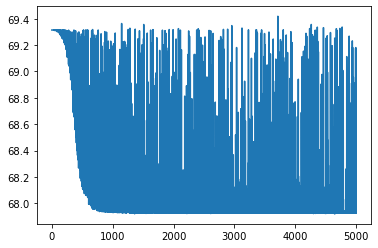

In [139]:
plt.plot(loss)

In [140]:
x0 = model(np.ones(2)*0.5, sigma = 0.001)
z = swyft.get_z(xz)
zlnL = swyft.estimate_lnL(net, x0, z, device = 'cuda:0')

(0.0, 1.1)

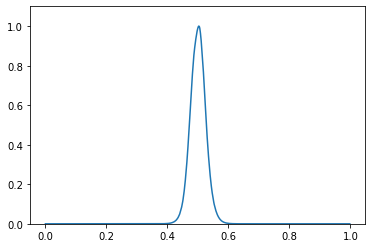

In [141]:
plt.plot(zlnL[0]['z'], np.exp(zlnL[0]['lnL']))
plt.ylim([0, 1.1])

In [142]:
from collections import defaultdict

In [143]:
def iter_sample_z(n_draws, n_dim, net, x0, device = 'cpu'):
    """Generate parameter samples z~p_c(z) from constrained prior.
    
    Arguments
    ---------
    n_draws: Number of draws
    n_dim: Number of dimensions of z
    net: Trained density network
    x0: Reference data
    
    Returns
    -------
    z: list of n_dim samples with length n_draws
    """
    done = False
    zout = defaultdict(lambda: [])
    counter = np.zeros(n_dim)
    while not done:
        z = swyft.sample_z(n_draws, n_dim)
        zlnL = swyft.estimate_lnL(net, x0, z, sort = False, device = device)
        for i in range(n_dim):
            mask = zlnL[i]['lnL'] > -13
            zout[i].append(zlnL[i]['z'][mask])
            counter[i] += mask.sum()
        done = min(counter) >= n_draws
    return np.array([np.concatenate(zout[i])[:n_draws] for i in range(n_dim)]).T

(0.0, 1.0)

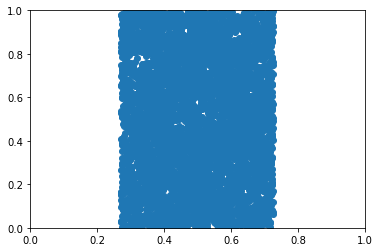

In [144]:
out = iter_sample_z(5000, 50, net, x0, device = 'cuda:0')
plt.scatter(out[:,0], out[:,2])
plt.xlim([0, 1])
plt.ylim([0, 1])

In [182]:
xz2 = swyft.sample_x(model, out)

100%|██████████| 5000/5000 [00:00<00:00, 12055.47it/s]


In [187]:
net2 = Network(10, 50, xz_init = xz2).cuda()

[ 0.4800603   0.34007563 -0.17811287 -0.4979542  -0.26407497  0.26391259
  0.49814691  0.17812538 -0.34014642 -0.47984431] [0.1253386  0.08926352 0.04759266 0.1302394  0.06959498 0.06947884
 0.1298935  0.04759072 0.0893337  0.12536304]
[0.50056212 0.5004114  0.5049783  0.50019226 0.50374814 0.49756075
 0.49905192 0.50114475 0.49455803 0.49487676 0.5040933  0.50720887
 0.50185746 0.50220858 0.4972541  0.49588706 0.50166069 0.49252297
 0.50238084 0.50119757 0.50470973 0.49945976 0.50522871 0.50471061
 0.50677298 0.49987825 0.50461313 0.50632737 0.49563942 0.4988343
 0.49019365 0.49687404 0.50483773 0.4988406  0.5083877  0.50119612
 0.48887074 0.50603243 0.49888514 0.49861653 0.49916175 0.49940997
 0.50180852 0.50232283 0.50171653 0.50618037 0.49997181 0.49762036
 0.50498979 0.49989404] [0.13045594 0.28729462 0.29040692 0.29149094 0.28767967 0.28831745
 0.28803412 0.29001173 0.28643978 0.29128894 0.28814812 0.29114812
 0.28891753 0.28747903 0.28851397 0.28820216 0.28886435 0.29053883
 0.2

In [200]:
loss += swyft.train(net2, xz2, n_steps = 300, lr = 1e-3, n_particles = 5, device = 'cuda:0')

100%|██████████| 300/300 [00:35<00:00,  8.43it/s]


In [203]:
x0 = model(np.ones(2)*0.50, sigma = 0.0001)
z = swyft.get_z(xz2)
zlnL = swyft.estimate_lnL(net2, x0, z, device = 'cuda:0')

(0.0, 1.0)

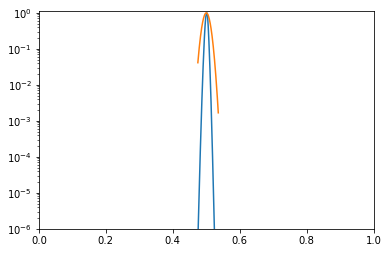

In [224]:
plt.plot(zlnL[0]['z'], np.exp(zlnL[0]['lnL']))
zz = zlnL[0]['z']
plt.plot(zz, np.exp(-(zz-0.5)**2/2/0.01**2))
plt.ylim([0.000001, 1.1])
plt.gca().set_yscale('log')
plt.xlim([0, 1])

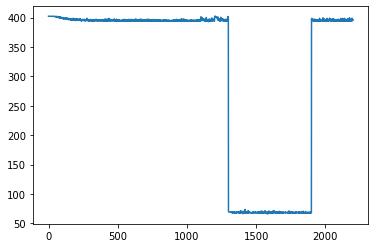

In [205]:
plt.plot(loss)

(0.0, 1.0)

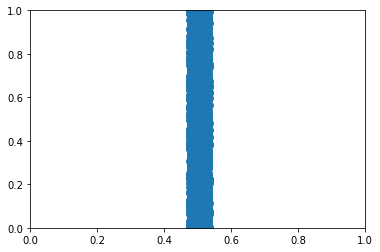

In [206]:
out = iter_sample_z(5000, 50, net2, x0, device = 'cuda:0')
plt.scatter(out[:,0], out[:,2])
plt.xlim([0, 1])
plt.ylim([0, 1])

In [207]:
xz3 = swyft.sample_x(model, out)
net3 = Network(10, 50, xz_init = xz3).cuda()

100%|██████████| 5000/5000 [00:00<00:00, 10619.72it/s]


[ 0.48416493  0.34331319 -0.17988746 -0.5026567  -0.26625759  0.26641332
  0.50279555  0.17957133 -0.34322707 -0.48439336] [0.01951412 0.01568121 0.0117476  0.02013787 0.01362127 0.01365615
 0.02025366 0.01173636 0.01563899 0.01962974]
[0.50508907 0.49724733 0.49409112 0.50656572 0.49987543 0.50637271
 0.50025625 0.50055075 0.50167662 0.49803769 0.5019723  0.49576015
 0.49954213 0.49528719 0.49763056 0.50159654 0.5049301  0.49854231
 0.49246636 0.50628869 0.50400606 0.49883556 0.49416176 0.50066576
 0.49811477 0.49439223 0.49498744 0.50089681 0.49358983 0.49603386
 0.49596302 0.50316011 0.50116499 0.49485322 0.4966236  0.50124044
 0.49707989 0.50310484 0.4961622  0.49996237 0.49781449 0.49493711
 0.5023378  0.50321892 0.50574673 0.50020425 0.49526666 0.50185776
 0.49937142 0.50100862] [0.0175284  0.28998137 0.28964053 0.2909744  0.28994346 0.2897614
 0.28694367 0.28907266 0.29079832 0.29228477 0.28714872 0.28825742
 0.28900569 0.28918323 0.28886632 0.2883505  0.28966834 0.28976917
 0.2

In [216]:
loss = swyft.train(net3, xz3, n_steps = 1000, lr = 1e-4, n_particles = 5, device = 'cuda:0')

 30%|███       | 304/1000 [00:35<01:21,  8.53it/s]


KeyboardInterrupt: 

In [219]:
x0 = model(np.ones(2)*0.50, sigma = 0.0000001)
z = swyft.get_z(xz3)
zlnL = swyft.estimate_lnL(net3, x0, z, device = 'cuda:0')

(0.0, 1.0)

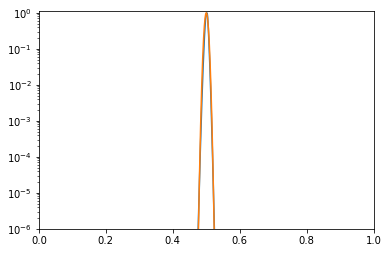

In [225]:
plt.plot(zlnL[0]['z'], np.exp(zlnL[0]['lnL']))
zz = zlnL[0]['z']
plt.plot(zz, np.exp(-(zz-0.5)**2/2/0.01**2/.1/2))
plt.ylim([0.000001, 1.1])
plt.gca().set_yscale('log')
plt.xlim([0, 1])